In [1]:
import os
import sys
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy import spatial
from matplotlib import pyplot as plt
from matplotlib import gridspec, cm
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import fiona
import geopandas as gpd
import seaborn as sns
from PIL import Image

from matplotlib.colors import LogNorm, ListedColormap
from shapely import geometry
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as pe

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.text as mtext
import matplotlib.font_manager as mfonts
import matplotlib as mpl
import pyproj
import cartopy.io.shapereader as shpreader
import cartopy.io.img_tiles as cimgt

import read_data, concatenation, radar

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
date = '20140811'

In [4]:
# Gage data
wu_df, wu_locs = read_data.read_wu_gages('../data/rain_gages')
# Radar data
radar_panel = read_data.radar_to_panel('../data/DTX_DPR_{0}.nc'.format(date))
# Vehicle data
veh = read_data.read_vehicle_data('../data/{0}.csv'.format(date))

In [5]:
# Get urban area
g = gpd.read_file('../data/cb_2014_us_ua10_500k.shp').query('NAME10 == "Ann Arbor, MI"')

In [6]:
# Correct gage data
wu_df = wu_df.loc[date]
wu_df.drop('KMIYPSIL10', axis=1, inplace=True)

In [7]:
# Correct vehicle data
ymin = radar_panel.major_axis.min()
ymax = radar_panel.major_axis.max()
xmin = radar_panel.minor_axis.min()
xmax = radar_panel.minor_axis.max()

veh = veh[(veh['Latitude'] > ymin) & (veh['Latitude'] < ymax) &
          (veh['Longitude'] > xmin) & (veh['Longitude'] < xmax)]
veh = veh[veh['GPS_Speed'] > 1]

# Get trip
trips = veh.reset_index().groupby('Trip')
long_trips = ((pd.to_datetime(trips['Time'].max()) - pd.to_datetime(trips['Time'].min()))
              .sort_values(ascending=False).head(50))
trip = 1188
veh_trip = veh[veh['Trip'] == 1188]
# Get radar
r_t, r_y, r_x = concatenation.panel_spacetime_index(radar_panel,
                                                    veh_trip.index,
                                                    veh_trip[['Longitude', 'Latitude']].values)
radar_trip = radar_panel.loc[veh_trip.index.min():veh_trip.index.max()].mean(axis=0).values

In [8]:
# Get gages
wu_df_sub = wu_df[wu_df.columns[wu_df.loc[veh_trip.index.min():veh_trip.index.max()].any()]]
wu_locs_sub = wu_locs.loc[wu_df.columns[wu_df.loc[veh_trip.index.min():veh_trip.index.max()].any()]]

spacetree = spatial.cKDTree(wu_locs_sub[['lon', 'lat']].values)
gage_dist, gage_ix = spacetree.query(veh_trip[['Longitude', 'Latitude']].values)

gage_trip = pd.Series([wu_df_sub[wu_locs_sub.index[gage_ix[i]]]
     .asof(veh_trip.index[i]) for i in range(len(veh_trip))],
                      index=veh_trip.index)

gages_used = wu_df_sub.columns[gage_ix].unique()

In [9]:
wash_zips = [48105,48104,48106,48109,48108,49236,48190,48189,48115,48191,
             49240,48198,48118,48197,48130,48137,48158,48160,48175,48176,48103]

wayne_zips = [48277,48101,
48111,48112,48120,48122,48124,48126,48125,48128,48127,48134,48135,48138,48141,48150,
48146,48152,48154,48164,48167,48168,48173,48170,48174,48180,48184,48183,48186,48185,
48188,48187,48192,48195,48193,48202,48201,48204,48203,48206,48205,48208,48207,48210,
48209,48212,48211,48214,48213,48216,48215,48218,48217,48219,48222,48221,48224,48223,
48226,48225,48228,48227,48230,48229,48234,48236,48235,48238,48240,48239,48266,48265]
zips = wash_zips + wayne_zips

In [10]:
roads = gpd.read_file('../data/allroads_miv14a.shp')
tiles = cimgt.StamenTerrain()
roads = roads[(roads['ZIPL'].isin(zips)) | (roads['ZIPR'].isin(zips))]

In [11]:
cam0 = mpimg.imread('../img/camera_0.png')
cam1 = mpimg.imread('../img/camera_1.png')

In [12]:
bbox = (radar_panel.minor_axis.min(), radar_panel.minor_axis.max(),
        radar_panel.major_axis.min(), radar_panel.major_axis.max())
xmin, xmax, ymin, ymax = bbox
bbox = geometry.box(xmin, ymin, xmax, ymax)

In [13]:
def add_osgb_scalebar(ax, at_x=(0.1, 0.4), at_y=(0.05, 0.075), max_stripes=5, zorder=0):
    """
    Add a scalebar to a GeoAxes of type cartopy.crs.OSGB (only).

    Args:
    * at_x : (float, float)
        target axes X coordinates (0..1) of box (= left, right)
    * at_y : (float, float)
        axes Y coordinates (0..1) of box (= lower, upper)
    * max_stripes
        typical/maximum number of black+white regions
    """
    # ensure axis is an OSGB map (meaning coords are just metres)
    # assert isinstance(ax.projection, ccrs.OSGB)
    # fetch axes coordinate mins+maxes
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    # set target rectangle in-visible-area (aka 'Axes') coordinates
    ax0, ax1 = at_x
    ay0, ay1 = at_y
    # choose exact X points as sensible grid ticks with Axis 'ticker' helper
    x_targets = [x0 + ax * (x1 - x0) for ax in (ax0, ax1)]
    ll = mpl.ticker.MaxNLocator(nbins=max_stripes, steps=[1,2,4,5,10])
    x_vals = ll.tick_values(*x_targets)
    # grab min+max for limits
    xl0, xl1 = x_vals[0], x_vals[-1]
    # calculate Axes Y coordinates of box top+bottom
    yl0, yl1 = [y0 + ay * (y1 - y0) for ay in [ay0, ay1]]
    # calculate Axes Y distance of ticks + label margins
    y_margin = (yl1-yl0)*0.25

    # fill black/white 'stripes' and draw their boundaries
    fill_colors = ['black', 'white']
    i_color = 0
    for xi0, xi1 in zip(x_vals[:-1],x_vals[1:]):
        # fill region
        ax.fill((xi0, xi1, xi1, xi0, xi0), (yl0, yl0, yl1, yl1, yl0),
                 fill_colors[i_color], zorder=zorder)
        # draw boundary
        ax.plot((xi0, xi1, xi1, xi0, xi0), (yl0, yl0, yl1, yl1, yl0),
                 'black', zorder=zorder)
        i_color = 1 - i_color

    # add short tick lines
    for x in x_vals:
        ax.plot((x, x), (yl0, yl0-y_margin), 'black', zorder=zorder)

    # add a scale legend 'Km'
    font_props = mfonts.FontProperties(size='medium')
    ax.text(
        0.5 * (xl0 + xl1),
        yl1 + y_margin,
        'km',
        verticalalignment='bottom',
        horizontalalignment='center',
        fontproperties=font_props, zorder=zorder, size=12)

    # add numeric labels
    for x in x_vals:
        ax.text(x,
                 yl0 - 2 * y_margin,
                 '{:g}'.format((x - xl0) * 0.001),
                 verticalalignment='top',
                 horizontalalignment='center',
                 fontproperties=font_props, zorder=zorder, size=12)
        
    patches = []
    framelx = xl0 - (0.15)*(xl1 - xl0)/2
    framely = yl0 - (3)*(yl1 - yl0)/2
    framewidth = 1.15*(xl1 - xl0)
    frameheight = 4.5*(yl1 - yl0)
    fancybox = mpatches.FancyBboxPatch(
        (framelx, framely), framewidth, frameheight,
        boxstyle=mpatches.BoxStyle("Round", pad=0.02))
    patches.append(fancybox)
    collection = PatchCollection(patches, color='white', alpha=0.5, zorder=zorder-1)
    ax.add_collection(collection)

In [75]:
tiles = cimgt.StamenTerrain()

fig = plt.figure(figsize=(16, 12))

fig.patch.set_facecolor('None')
fig.patch.set_alpha(0)

gs = gridspec.GridSpec(3, 4, height_ratios=(2.2, 1, 1))

veh_cmap = cm.get_cmap('Greys', 4)

cmap = cm.gist_ncar
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
my_cmap = ListedColormap(my_cmap)

transformed_extent = tiles.crs.transform_points(ccrs.Geodetic(), np.asarray([xmin, xmax]), np.asarray([ymin, ymax]))

radar_plot = (pd.Series(radar_panel.values[r_t, r_y, r_x], index=veh_trip.index)
              ).resample('10s').mean()
gage_plot = gage_trip.resample('10s').mean()
veh_plot = veh_trip['Wiper'].resample('10s').mean().interpolate()

ax1 = fig.add_subplot(gs[1:, :2], projection=tiles.crs)
ax1.set_extent([xmin+0.27, xmax-0.29, ymin+0.115, ymax-0.07])


roads.to_crs(tiles.crs.proj4_init).plot(ax=ax1, linewidth=0.5, color='k', alpha=0.5, zorder=3)


radar_im = ax1.imshow(25.4*radar_trip, cmap=my_cmap,
                     extent=(transformed_extent[:, 0].tolist() + transformed_extent[:, 1].tolist()),
                     origin='lower', zorder=4, norm=LogNorm(vmin=2.5e-2, vmax=250),
                    transform=tiles.crs, alpha=0.99)

veh_scat = ax1.scatter(veh_trip['Longitude'], veh_trip['Latitude'], c=veh_trip['Wiper'], s=20,
                                       cmap=veh_cmap, linewidth=0, zorder=5, vmin=0, vmax=3, 
                       transform=ccrs.Geodetic())
veh_line2 = ax1.plot(veh_trip['Longitude'].values, veh_trip['Latitude'].values, zorder=4, color='0.2', linewidth=9,
                       transform=ccrs.Geodetic())

gage_scat = ax1.scatter(wu_locs.loc[gages_used, 'lon'],
            wu_locs.loc[gages_used, 'lat'],
            marker='o', c='b', zorder=5, transform=ccrs.Geodetic(),
                       s=140)

ax1.background_patch.set_facecolor('0.86')
ax1.background_patch.set_alpha(0.6)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])

r_cb = plt.colorbar(radar_im, orientation='horizontal', label='Radar Rain Intensity (mm/hr)',
                    ax=ax1, fraction=0.05, pad=0.05, aspect=27)
r_cb.set_label('Radar Rain Intensity (mm/hr)', fontsize=12)

ax2 = fig.add_subplot(gs[1,2:])
ax3 = fig.add_subplot(gs[2,2:])

ax1.patch.set_facecolor('White')

ax2.fill_between(gage_plot.index.values.astype(int), 25.4*gage_plot.fillna(0).div(10).values, 0, linewidth=1.2, color='b', alpha=0.1)
ax2.fill_between(radar_plot.index.values.astype(int), 25.4*radar_plot.fillna(0).values, 0, linewidth=1.2, color='r', alpha=0.1)
ax2.plot(gage_plot.index, 25.4*gage_plot.fillna(0).div(10).values, linewidth=1.2, color='b', label='Gage', alpha=1)
ax2.plot(radar_plot.index, 25.4*radar_plot.fillna(0).values, linewidth=1.2, color='r', label='Radar', alpha=1)

ax3.fill_between(veh_plot.index.values.astype(int), veh_plot.values, 0, color='k', linewidth=1.2, alpha=0.1, zorder=2)
ax3.plot(veh_plot.index, veh_plot.values, color='k', linewidth=1.2, label='Wiper', alpha=1, zorder=2)


red_patch = mpatches.Patch(facecolor='k', label='High', linewidth=1.2, edgecolor='k')
yellow_patch = mpatches.Patch(facecolor='0.5', label='Medium', linewidth=1.2, edgecolor='k')
cyan_patch = mpatches.Patch(facecolor='0.75', label='Low', linewidth=1.2, edgecolor='k')
blue_patch = mpatches.Patch(facecolor='1.0', label='Off', linewidth=1.2, edgecolor='k')

#leg0 = ax1.legend(handles=[red_patch, yellow_patch, cyan_patch, blue_patch],
#          frameon=True, fontsize=12, loc=(0.82, 0.73))
#ax1.text(0.82, 0.955, "Wiper intensity", transform=ax1.transAxes, fontsize=12, fontweight='bold', zorder=8)
leg0 = ax1.legend(handles=[red_patch, yellow_patch, cyan_patch, blue_patch],
          frameon=True, fontsize=12, title='Wiper intensity')
ax1.get_legend().get_title().set_fontsize(12)
ax1.get_legend().get_title().set_fontweight('bold')
#ax1.get_legend().get_title().set_position((0, -10))

#ax1.set_xlim(-83.95, -83.4)
#ax1.set_ylim(ymin, ymax)
ax1.grid('off')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('Rain intensity (mm/hr)', labelpad=12, fontsize=12)
ax2.legend(frameon=True, fontsize=12)
ax2.grid('on')
ax2.set_xlim(radar_plot.index.values.astype(int)[0], radar_plot.index.values.astype(int)[-1])
ax3.set_ylim(-0.1, 3)
ax3.legend(frameon=True, fontsize=12)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position('right')
ax3.set_ylabel('Wiper intensity', labelpad=12, fontsize=12)
ax3.grid('on')
ax3.set_xlim(radar_plot.index.values.astype(int)[0], radar_plot.index.values.astype(int)[-1])

startcoords = tiles.crs.transform_points(ccrs.Geodetic(), np.asarray(veh_trip['Longitude'].values[0]), np.asarray(veh_trip['Latitude'].values[0]))
endcoords = tiles.crs.transform_points(ccrs.Geodetic(), np.asarray(veh_trip['Longitude'].values[-1]), np.asarray(veh_trip['Latitude'].values[-1]))
startx = startcoords[0][0]
starty = startcoords[0][1]
endx = endcoords[0][0]
endy = endcoords[0][1]

ax1.annotate('Start', xy=(startx, starty), xytext=(startx, starty + 1200),
            zorder=6, fontsize=13, bbox=dict(boxstyle="round", fc=leg0.properties()['frame'].properties()['facecolor'], 
                                             alpha=leg0.properties()['frame'].properties()['alpha'], linewidth=1)
            )

ax1.annotate('End', xy=(endx, endy), xytext=(endx, endy - 1200),
            zorder=6, fontsize=13, bbox=dict(boxstyle="round", fc=leg0.properties()['frame'].properties()['facecolor'], 
                                             alpha=leg0.properties()['frame'].properties()['alpha'], linewidth=1)
            )


blips = veh_plot[(veh_plot > 0) & (veh_plot < 0.5)][-2:].index
for blip in blips:
    lats = (veh_trip['Latitude'].at[blip].mean(),)
    lons = (veh_trip['Longitude'].at[blip].mean(),)
    ax1.scatter(lons, lats, c=[1], s=40, cmap=veh_cmap, linewidth=1, zorder=6, vmin=0, vmax=3, 
                       transform=ccrs.Geodetic(), edgecolor='k')

plt.tight_layout()
t2 = ax3.set_xticklabels(list(pd.to_datetime(ax3.get_xticks()).strftime('%H:%M')),
                        rotation=45)

ax2.set_xticklabels([])

ax4 = fig.add_subplot(gs[0, :2])    
ax5 = fig.add_subplot(gs[0, 2:])    
ax4.grid('off')
ax5.grid('off')

ax4.imshow(cam1[:, 0:800])
ax5.imshow(cam0[:, 0:800])
ax4.set_xticklabels([])
ax5.set_xticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])

add_osgb_scalebar(ax1, at_x=(0.8, 0.95), at_y=(0.075, 0.115), zorder=5, max_stripes=3)

plt.savefig('../img/fig2_precropped.png', bbox_inches='tight')
plt.close()

In [76]:
crop = Image.open('../img/fig2_precropped.png')
dims = crop.getbbox()
new_img = Image.new('RGBA', (1144, 220 + (773 - 335)))
new_img.paste(crop.crop((0, 0, 1144, 220)), (0,0))
new_img.paste(crop.crop((0, 335, 1144, 773)), (0,220))
new_img.save('../img/fig2_cropped.png')

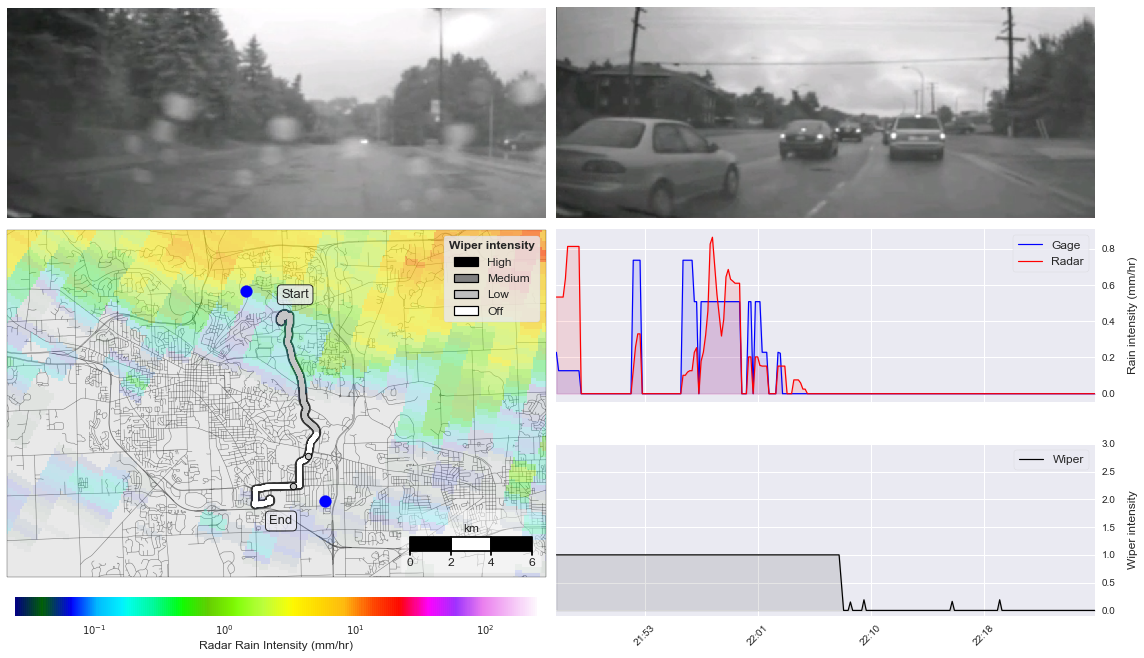

In [77]:
new_img